In [29]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
train_paths = glob.glob('./train/*/*.png')
train_paths[:10]

['./train/PMCI/029_S_1073_78.png',
 './train/PMCI/116_S_1315_35.png',
 './train/PMCI/029_S_0878_50.png',
 './train/PMCI/035_S_0292_68.png',
 './train/PMCI/002_S_0729_80.png',
 './train/PMCI/027_S_0461_101.png',
 './train/PMCI/128_S_2130_94.png',
 './train/PMCI/027_S_0408_54.png',
 './train/PMCI/027_S_0835_100.png',
 './train/PMCI/002_S_1070_74.png']

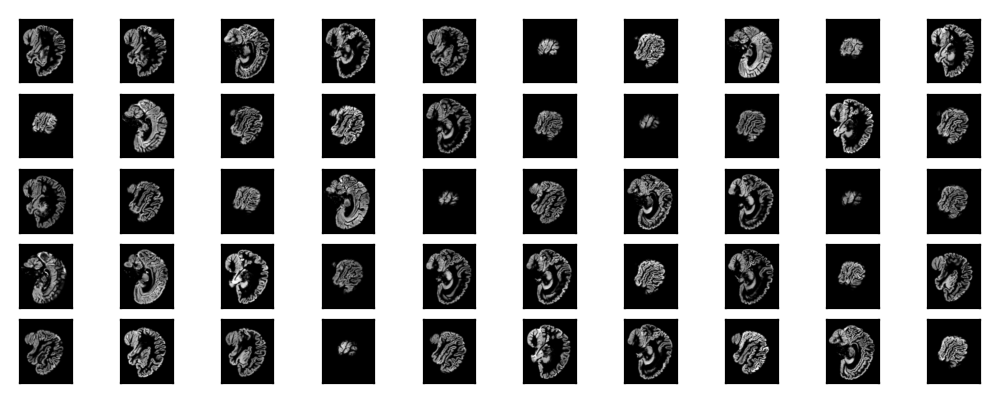

In [31]:
plt.figure(dpi=200)
idx = 0 
for path in train_paths[:50]:
    img = cv2.imread(path)
    idx += 1
    plt.subplot(10, 10, idx)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])

In [32]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import torch
import timm
m = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)

In [ ]:
train_feats = []
train_label = []
for path in train_paths[:]:
    img = cv2.imread(path)
    with torch.no_grad():
        img = torch.from_numpy(img) / 255.0
        img = img[:, :, :, None]
        img = torch.transpose(img, 3, 0)
        img = torch.transpose(img, 2, 1)
        feat = m(img)
        train_feats.append(feat)
    if 'PMCI' in path:
        train_label.append(1)
    else:
        train_label.append(0)

train_feats = torch.cat(train_feats, 0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
pred = cross_val_predict(
    LogisticRegression(),
    train_feats.data.numpy(),
    train_label
)

f1_score(train_label, list(pred))

In [ ]:
model =  LogisticRegression()
model.fit(train_feats.data.numpy(), train_label)

In [ ]:
test_feats = []
for i in range(1, 201):
    img = cv2.imread(f"./test/{i}.png")
    with torch.no_grad():
        img = torch.from_numpy(img) / 255.0
        img = img[:, :, :, None]
        img = torch.transpose(img, 3, 0)
        img = torch.transpose(img, 2, 1)
        feat = m(img)
        test_feats.append(feat)

test_feats = torch.cat(test_feats, 0)

In [ ]:
val_label = pd.DataFrame()
val_label['uuid'] = range(1, 201)
val_label['label'] = model.predict(test_feats)
val_label["label"] = val_label["label"].map({1: "PMCI", 0: "SMCI"})
val_label.to_csv('submit.csv', index=None)